# GAN Fashion MNIST

## Project Preparation

In [1]:
!pip install idx2numpy
!pip install tensorflow-gan

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7905 sha256=482d16976445b7fe047d5196f89069f07fb33f2f32b495e87ea651c590e9dc18
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 2.9 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
#import model 
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import idx2numpy
import keras
import tensorflow as tf
import tensorflow_gan as tfgan
from tensorflow.keras.layers import Conv2D, Convolution2DTranspose,Embedding, MaxPool2D, Flatten, Dense, Reshape, Input,  Concatenate,Lambda
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam,SGD
import optuna
from tensorflow.image import ssim

2024-07-07 14:29:07.530934: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 14:29:07.531033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 14:29:07.667676: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#download data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz # data gambar train
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz #data label train

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-07-07 14:29:19--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.75.90, 3.5.135.94, 52.219.170.104, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.75.90|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: 'train-images-idx3-ubyte.gz'

train-images-idx3-u 100%[===================>]  25.20M  15.1MB/s    in 1.7s    

2024-07-07 14:29:21 (15.1 MB/s) - 'train-images-idx3-ubyte.gz' saved [26421880/26421880]

--2024-07-07 14:29:22--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.170.84, 52.219.168.82, 3.5.134.1

In [4]:
#extracting images and labels
!gunzip /kaggle/working/train-labels-idx1-ubyte.gz
!gunzip /kaggle/working/train-images-idx3-ubyte.gz

In [11]:
#convert image and label into numpy labels
train_img = '/kaggle/working/train-images-idx3-ubyte'
train_label = '/kaggle/working/train-labels-idx1-ubyte'

train_img_arr = idx2numpy.convert_from_file(train_img)
train_label_arr = idx2numpy.convert_from_file(train_label)

### Filter data

In [12]:
#filtering data by label (label 0 (T shirt / top) and 1 (Trouser))
indx = np.where((train_label_arr == 0) | (train_label_arr == 1))[0]
filter_img_data = train_img_arr[indx]
filter_label_data = train_label_arr[indx]

print('Full data shape : ')
print('Image data  : ',train_img_arr.shape)
print('Label data:',train_label_arr.shape)

print('filtered data (T-shirt/top and trouser) :')
print('Image data  : ',filter_img_data.shape)
print('Label data:',filter_label_data.shape)

Full data shape : 
Image data  :  (60000, 28, 28)
Label data: (60000,)
filtered data (T-shirt/top and trouser) :
Image data  :  (12000, 28, 28)
Label data: (12000,)


### Preprocessing gambar

In [13]:
#scale data with tanh
filter_img_data = filter_img_data.astype(float)
filter_img_data /= (255.0)
filter_img_data = (filter_img_data * 2) - 1

In [14]:
#reshaping data
filter_img_data = filter_img_data.reshape(-1,28,28,1)

In [15]:
#splits data to 80% train, 10% validation and 10% test
length_data = len(filter_img_data)
train_pivot = round(0.8 * length_data)
val_pivot = round(0.9* length_data)

train_img_data = filter_img_data[:train_pivot]
val_img_data = filter_img_data[train_pivot:val_pivot]
test_img_data = filter_img_data[val_pivot:]

train_img_label = filter_label_data[:train_pivot]
val_img_label = filter_label_data[train_pivot:val_pivot]
test_img_label = filter_label_data[val_pivot:]

In [16]:
#initialize total class, noise dimension and image shape
total_class = 2
noise_dim = 50
img_shape = 28

### Generator

In [17]:
#make a generator model
class generator:
    def __init__(self,noise_dim, img_shape, total_class):
        self.noise_dim = noise_dim
        self.img_shape = img_shape
        self.total_class = total_class
        self.model = None
    def set_model(self):
        label_input = Input(shape = (1,))
        noise_input = Input(shape = (self.noise_dim,))

        lab_embed = Embedding(self.total_class, self.noise_dim)(label_input)
        lab_embed = Flatten()(lab_embed)
        generator = Concatenate()([noise_input, lab_embed])

        generator = Dense(128)(generator)
        generator = Dense(256)(generator)
        generator = Dense(512)(generator)
        generator = Dense(1024)(generator)

        generator = Dense(self.img_shape * self.img_shape ,activation = 'tanh')(generator)
        generator = Reshape((self.img_shape, self.img_shape, 1))(generator) 
        generator = Model([noise_input, label_input], generator, name = 'generator')

        self.model = generator
    def get_model(self):
        return self.model

generator_model = generator(noise_dim,img_shape,total_class)
generator_model.set_model()
generator_model = generator_model.get_model()

generator_model.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                100       ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 flatten (Flatten)           (None, 50)                   0         ['embedding[0][0]']           
                                                                                          

## Discriminator

In [18]:
#make discriminator model
class discriminator:
    def __init__(self, noise_dim, img_shape, total_class):
        self.noise_dim = noise_dim
        self.img_shape = img_shape
        self.total_class = total_class
        self.model = None

    def set_model(self):
        img_input = Input(shape=(self.img_shape, self.img_shape, 1))
        label_input = Input(shape=(1,))
        lab_embed = Embedding(self.total_class, self.img_shape * self.img_shape)(label_input)
        lab_embed = Flatten()(lab_embed)
        lab_embed = Reshape((self.img_shape, self.img_shape, 1))(lab_embed)
        discriminator = Concatenate()([img_input, lab_embed])
        discriminator = Flatten()(discriminator) 
        discriminator = Dense(512)(discriminator)
        discriminator = Dense(1024)(discriminator)
        discriminator = Dense(1024)(discriminator)
        discriminator = Dense(512)(discriminator)
        discriminator = Dense(1, activation='sigmoid')(discriminator)
        discriminator = Model([img_input, label_input], discriminator, name='discriminator')
        self.model = discriminator
        self.model.compile(optimizer=Adam(learning_rate=0.00005, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

    def get_model(self):
        return self.model

discriminator_model = discriminator(noise_dim,img_shape,total_class)
discriminator_model.set_model()

discriminator_model = discriminator_model.get_model()

discriminator_model.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 784)               1568      ['input_4[0][0]']             
                                                                                                  
 flatten_1 (Flatten)         (None, 784)                  0         ['embedding_1[0][0]']         
                                                                                                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                      

### GAN Model

In [19]:
#make GAN model, combining generator and discriminator
class GAN:
    def __init__(self, generator, discriminator, batch_size, noise_size, total_class):
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.noise_size = noise_size
        self.total_class = total_class
        
        self.final_model = None
        self.train_data = None
        
    #set GAN model with discriminator model and generator created
    def set_gan_model(self):
        self.discriminator.trainable = False
        noise_input = Input(shape=(self.noise_size,))
        label_input = Input(shape=(1,))
        
        generated_image = self.generator([noise_input, label_input])
        validity = self.discriminator([generated_image, label_input])
        
        self.final_model = Model([noise_input, label_input], validity, name = 'GAN')
        self.final_model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.00005, beta_1=0.5))
    
    #return GAN model
    def get_gan_model(self):
        return self.final_model
    
    #set data train
    def set_train_data(self, train_data):
        self.train_data = train_data
    
    #make fake sample data
    def get_fake_sample(self):
        half_batch = self.batch_size//2
        x = np.random.randn(half_batch, self.noise_size)
        y = np.random.randint(0, self.total_class, half_batch).reshape(-1, 1)  
        return x, y
    
    #make real sample data
    def get_real_sample(self):
        half_batch = self.batch_size//2
        idx = np.random.randint(0, self.train_data.shape[0], half_batch)
        x = self.train_data[idx]
        return x 
    
    #preview temporary results
    def preview_generated_images(self, n_samples=4):
        x_fake = np.random.randn(n_samples, self.noise_size)
        y_fake = np.random.randint(0, self.total_class, n_samples).reshape(-1, 1)

        result = self.generator.predict([x_fake, y_fake])

        fig, axes = plt.subplots(1,n_samples, figsize=(10, 5))
        for i, ax in enumerate(axes.flat):
            ax.imshow(result[i].squeeze(), cmap='gray')
            ax.axis('off')

        plt.tight_layout()
        plt.show()
        
    #training model
    def train(self, epochs):
        half_batch = self.batch_size // 2
        for i in range(epochs):
            if i % 10 == 0:
                self.preview_generated_images(4)
            for j in range(epochs // 2):
                
                #create fake image and label data
                noise, labels = self.get_fake_sample()
                fake_images = self.generator.predict([noise, labels])
                
                # buat data gambar dan label asli
                real_images = self.get_real_sample()
                real_labels = np.random.randint(0, self.total_class, half_batch).reshape(-1, 1)
                
                # label initialisation with smoothing for real data
                y_real = np.ones((half_batch, 1)) * 0.9
                y_fake = np.zeros((half_batch, 1))
                
                #update discriminator weight
                self.discriminator.trainable = True
                real_discriminator_loss = self.discriminator.train_on_batch([real_images, real_labels], y_real)
                fake_discriminator_loss = self.discriminator.train_on_batch([fake_images, labels], y_fake)
                total_discriminator_loss = 0.5 * np.add(real_discriminator_loss, fake_discriminator_loss)

                #update generator weight
                self.discriminator.trainable = False
                noise, labels = self.get_fake_sample()
                g_y = np.ones((half_batch, 1))
                g_loss = self.final_model.train_on_batch([noise, labels], g_y)

                if j % 50 == 0:
                    print(f"Epoch: {i+1}, Batch: {j}, D Loss: {total_discriminator_loss[0]}, D Acc: {total_discriminator_loss[1]}, G Loss: {g_loss}")
            
                    


gan_model = GAN(generator_model, discriminator_model, 100, noise_dim,total_class)
gan_model.set_train_data(train_img_data)
gan_model.set_gan_model()    

gan_model.get_gan_model().summary()
        

Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 generator (Functional)      (None, 28, 28, 1)            1506548   ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                                  
 discriminator (Functional)  (None, 1)                    2905121   ['generator[0][0]',         

1/1 [==============================] - 0s 301ms/step


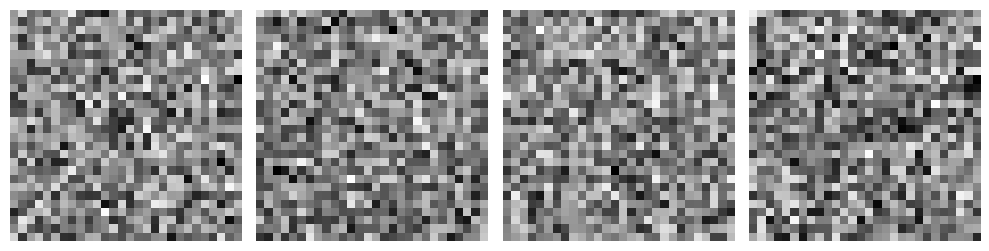

2/2 [==============================] - 0s 3ms/step


I0000 00:00:1720362587.377229     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch: 1, Batch: 0, D Loss: 0.8867540657520294, D Acc: 0.2199999988079071, G Loss: 0.6743052005767822
2/2 [==============================] - 0s 3ms/step
Epoch: 1, Batch: 50, D Loss: 0.32890521734952927, D Acc: 0.49000000953674316, G Loss: 2.7607452869415283
2/2 [==============================] - 0s 3ms/step
Epoch: 2, Batch: 0, D Loss: 0.27876920625567436, D Acc: 0.5, G Loss: 3.3991570472717285
2/2 [==============================] - 0s 3ms/step
Epoch: 2, Batch: 50, D Loss: 0.18197402823716402, D Acc: 0.5, G Loss: 4.025539875030518
2/2 [==============================] - 0s 2ms/step
Epoch: 3, Batch: 0, D Loss: 0.24605646543204784, D Acc: 0.5, G Loss: 4.308597087860107
2/2 [==============================] - 0s 3ms/step
Epoch: 3, Batch: 50, D Loss: 0.4576121121644974, D Acc: 0.46000000834465027, G Loss: 3.2096927165985107
2/2 [==============================] - 0s 3ms/step
Epoch: 4, Batch: 0, D Loss: 0.7168569564819336, D Acc: 0.3400000035762787, G Loss: 2.5667340755462646
2/2 [=============

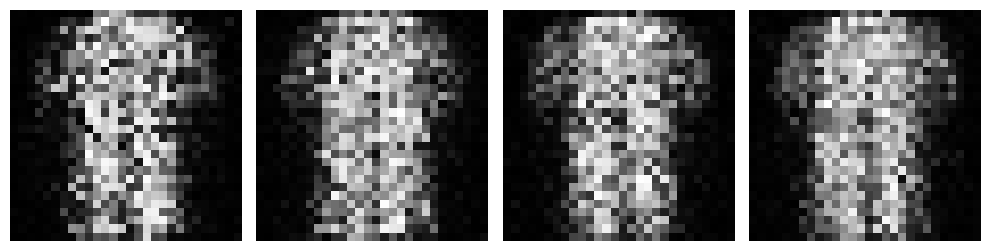

2/2 [==============================] - 0s 3ms/step
Epoch: 11, Batch: 0, D Loss: 0.7172970175743103, D Acc: 0.4000000059604645, G Loss: 0.9269108772277832
2/2 [==============================] - 0s 3ms/step
Epoch: 11, Batch: 50, D Loss: 0.6767319738864899, D Acc: 0.44999998807907104, G Loss: 0.9562633037567139
2/2 [==============================] - 0s 2ms/step
Epoch: 12, Batch: 0, D Loss: 0.6703784167766571, D Acc: 0.38999998569488525, G Loss: 1.0273277759552002
2/2 [==============================] - 0s 3ms/step
Epoch: 12, Batch: 50, D Loss: 0.6871933043003082, D Acc: 0.41999998688697815, G Loss: 0.9508030414581299
2/2 [==============================] - 0s 3ms/step
Epoch: 13, Batch: 0, D Loss: 0.7346075475215912, D Acc: 0.33000001311302185, G Loss: 0.8270704746246338
2/2 [==============================] - 0s 3ms/step
Epoch: 13, Batch: 50, D Loss: 0.6820369064807892, D Acc: 0.44999998807907104, G Loss: 0.9335616827011108
2/2 [==============================] - 0s 3ms/step
Epoch: 14, Batch:

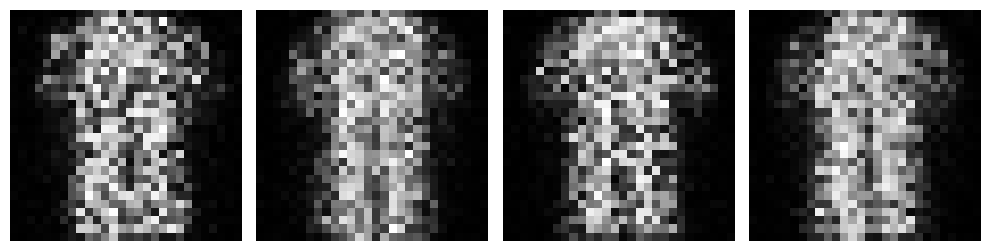

2/2 [==============================] - 0s 3ms/step
Epoch: 21, Batch: 0, D Loss: 0.7011231780052185, D Acc: 0.4300000071525574, G Loss: 0.8391435146331787
2/2 [==============================] - 0s 3ms/step
Epoch: 21, Batch: 50, D Loss: 0.6938425004482269, D Acc: 0.4699999988079071, G Loss: 0.812674880027771
2/2 [==============================] - 0s 3ms/step
Epoch: 22, Batch: 0, D Loss: 0.7041342854499817, D Acc: 0.49000000953674316, G Loss: 0.8194612264633179
2/2 [==============================] - 0s 3ms/step
Epoch: 22, Batch: 50, D Loss: 0.6898385584354401, D Acc: 0.47999998927116394, G Loss: 0.8405129909515381
2/2 [==============================] - 0s 3ms/step
Epoch: 23, Batch: 0, D Loss: 0.699632853269577, D Acc: 0.49000000953674316, G Loss: 0.8288803100585938
2/2 [==============================] - 0s 3ms/step
Epoch: 23, Batch: 50, D Loss: 0.7024793326854706, D Acc: 0.4399999976158142, G Loss: 0.8037452101707458
2/2 [==============================] - 0s 3ms/step
Epoch: 24, Batch: 0, 

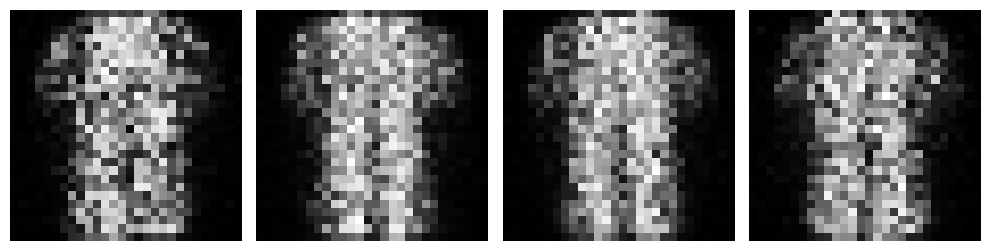

2/2 [==============================] - 0s 3ms/step
Epoch: 31, Batch: 0, D Loss: 0.6886430978775024, D Acc: 0.47999998927116394, G Loss: 0.8319749236106873
2/2 [==============================] - 0s 2ms/step
Epoch: 31, Batch: 50, D Loss: 0.6857653260231018, D Acc: 0.5, G Loss: 0.8278427124023438
2/2 [==============================] - 0s 3ms/step
Epoch: 32, Batch: 0, D Loss: 0.6879156827926636, D Acc: 0.49000000953674316, G Loss: 0.8453404307365417
2/2 [==============================] - 0s 3ms/step
Epoch: 32, Batch: 50, D Loss: 0.6964941918849945, D Acc: 0.46000000834465027, G Loss: 0.8295121788978577
2/2 [==============================] - 0s 2ms/step
Epoch: 33, Batch: 0, D Loss: 0.6926126480102539, D Acc: 0.4699999988079071, G Loss: 0.8187370300292969
2/2 [==============================] - 0s 3ms/step
Epoch: 33, Batch: 50, D Loss: 0.700859546661377, D Acc: 0.47999998927116394, G Loss: 0.8200620412826538
2/2 [==============================] - 0s 2ms/step
Epoch: 34, Batch: 0, D Loss: 0.698

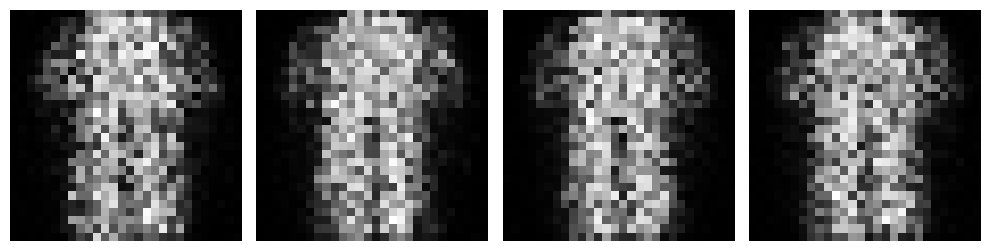

2/2 [==============================] - 0s 3ms/step
Epoch: 41, Batch: 0, D Loss: 0.69057297706604, D Acc: 0.49000000953674316, G Loss: 0.8452404737472534
2/2 [==============================] - 0s 3ms/step
Epoch: 41, Batch: 50, D Loss: 0.6872089505195618, D Acc: 0.49000000953674316, G Loss: 0.8167997598648071
2/2 [==============================] - 0s 3ms/step
Epoch: 42, Batch: 0, D Loss: 0.6859919428825378, D Acc: 0.5, G Loss: 0.8323847055435181
2/2 [==============================] - 0s 3ms/step
Epoch: 42, Batch: 50, D Loss: 0.6874433159828186, D Acc: 0.5, G Loss: 0.8130989670753479
2/2 [==============================] - 0s 3ms/step
Epoch: 43, Batch: 0, D Loss: 0.6980373561382294, D Acc: 0.49000000953674316, G Loss: 0.8333691358566284
2/2 [==============================] - 0s 3ms/step
Epoch: 43, Batch: 50, D Loss: 0.6959196925163269, D Acc: 0.47999998927116394, G Loss: 0.8097984194755554
2/2 [==============================] - 0s 3ms/step
Epoch: 44, Batch: 0, D Loss: 0.6978850662708282, D

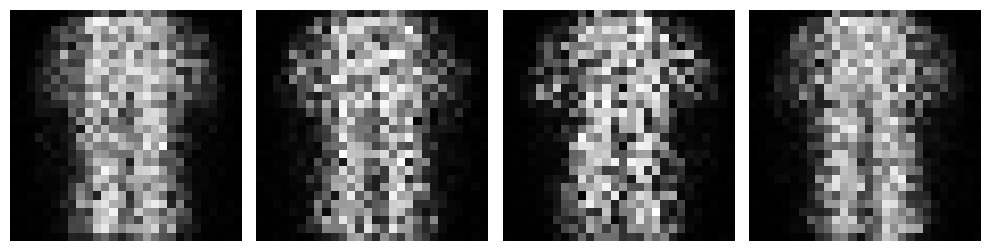

2/2 [==============================] - 0s 3ms/step
Epoch: 51, Batch: 0, D Loss: 0.6880695521831512, D Acc: 0.44999998807907104, G Loss: 0.8381358981132507
2/2 [==============================] - 0s 3ms/step
Epoch: 51, Batch: 50, D Loss: 0.7095998525619507, D Acc: 0.4699999988079071, G Loss: 0.8310472369194031
2/2 [==============================] - 0s 3ms/step
Epoch: 52, Batch: 0, D Loss: 0.6946283578872681, D Acc: 0.49000000953674316, G Loss: 0.8282370567321777
2/2 [==============================] - 0s 3ms/step
Epoch: 52, Batch: 50, D Loss: 0.6841638386249542, D Acc: 0.44999998807907104, G Loss: 0.8715906739234924
2/2 [==============================] - 0s 2ms/step
Epoch: 53, Batch: 0, D Loss: 0.6980084180831909, D Acc: 0.49000000953674316, G Loss: 0.8238827586174011
2/2 [==============================] - 0s 3ms/step
Epoch: 53, Batch: 50, D Loss: 0.6936626136302948, D Acc: 0.5, G Loss: 0.8573520183563232
2/2 [==============================] - 0s 3ms/step
Epoch: 54, Batch: 0, D Loss: 0.69

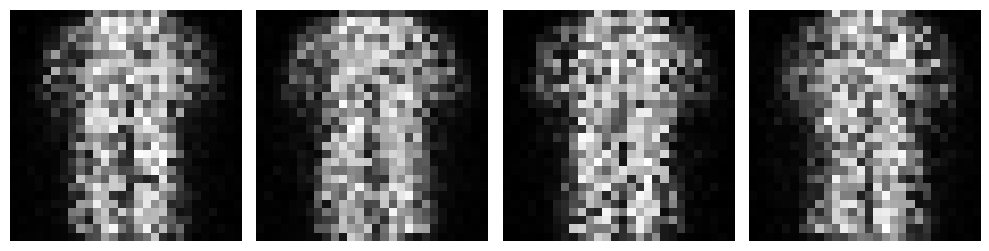

2/2 [==============================] - 0s 3ms/step
Epoch: 61, Batch: 0, D Loss: 0.7006494402885437, D Acc: 0.44999998807907104, G Loss: 0.8402674198150635
2/2 [==============================] - 0s 3ms/step
Epoch: 61, Batch: 50, D Loss: 0.6982081234455109, D Acc: 0.47999998927116394, G Loss: 0.860124409198761
2/2 [==============================] - 0s 2ms/step
Epoch: 62, Batch: 0, D Loss: 0.6864681243896484, D Acc: 0.46000000834465027, G Loss: 0.8358991146087646
2/2 [==============================] - 0s 3ms/step
Epoch: 62, Batch: 50, D Loss: 0.696212887763977, D Acc: 0.38999998569488525, G Loss: 0.8352770209312439
2/2 [==============================] - 0s 3ms/step
Epoch: 63, Batch: 0, D Loss: 0.7069175839424133, D Acc: 0.44999998807907104, G Loss: 0.8504840135574341
2/2 [==============================] - 0s 3ms/step
Epoch: 63, Batch: 50, D Loss: 0.6997117102146149, D Acc: 0.46000000834465027, G Loss: 0.82603919506073
2/2 [==============================] - 0s 3ms/step
Epoch: 64, Batch: 0,

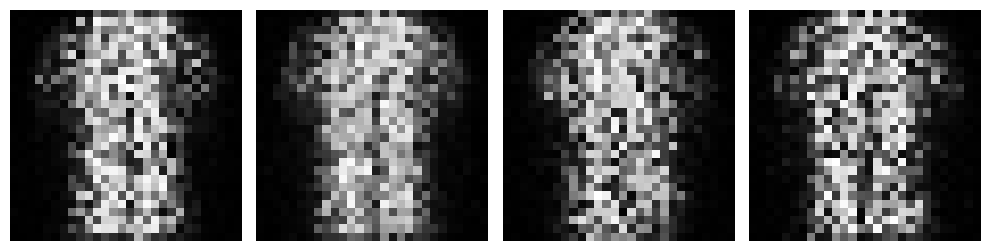

2/2 [==============================] - 0s 3ms/step
Epoch: 71, Batch: 0, D Loss: 0.6979323327541351, D Acc: 0.4399999976158142, G Loss: 0.8294489979743958
2/2 [==============================] - 0s 3ms/step
Epoch: 71, Batch: 50, D Loss: 0.6806239187717438, D Acc: 0.5, G Loss: 0.8338554501533508
2/2 [==============================] - 0s 3ms/step
Epoch: 72, Batch: 0, D Loss: 0.685194581747055, D Acc: 0.5, G Loss: 0.8430586457252502
2/2 [==============================] - 0s 3ms/step
Epoch: 72, Batch: 50, D Loss: 0.6958070993423462, D Acc: 0.49000000953674316, G Loss: 0.8257057070732117
2/2 [==============================] - 0s 4ms/step
Epoch: 73, Batch: 0, D Loss: 0.6976596713066101, D Acc: 0.4399999976158142, G Loss: 0.8203971982002258
2/2 [==============================] - 0s 3ms/step
Epoch: 73, Batch: 50, D Loss: 0.6978419125080109, D Acc: 0.44999998807907104, G Loss: 0.8313908576965332
2/2 [==============================] - 0s 3ms/step
Epoch: 74, Batch: 0, D Loss: 0.6957788467407227, D 

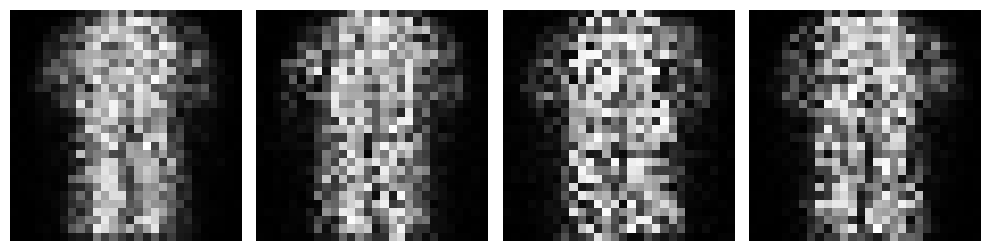

2/2 [==============================] - 0s 4ms/step
Epoch: 81, Batch: 0, D Loss: 0.701233834028244, D Acc: 0.4399999976158142, G Loss: 0.8143092393875122
2/2 [==============================] - 0s 3ms/step
Epoch: 81, Batch: 50, D Loss: 0.6961221396923065, D Acc: 0.49000000953674316, G Loss: 0.8346710205078125
2/2 [==============================] - 0s 3ms/step
Epoch: 82, Batch: 0, D Loss: 0.6856285333633423, D Acc: 0.5, G Loss: 0.8265016078948975
2/2 [==============================] - 0s 3ms/step
Epoch: 82, Batch: 50, D Loss: 0.6937832236289978, D Acc: 0.5, G Loss: 0.8273497819900513
2/2 [==============================] - 0s 3ms/step
Epoch: 83, Batch: 0, D Loss: 0.6964090466499329, D Acc: 0.4699999988079071, G Loss: 0.8114286661148071
2/2 [==============================] - 0s 3ms/step
Epoch: 83, Batch: 50, D Loss: 0.6827353835105896, D Acc: 0.5, G Loss: 0.8268957734107971
2/2 [==============================] - 0s 3ms/step
Epoch: 84, Batch: 0, D Loss: 0.6854086816310883, D Acc: 0.5, G Loss

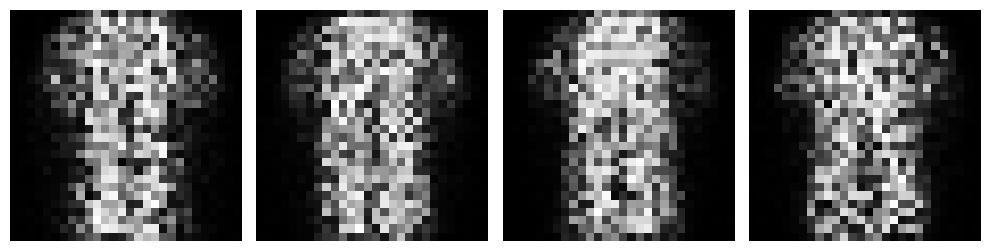

2/2 [==============================] - 0s 4ms/step
Epoch: 91, Batch: 0, D Loss: 0.6930314898490906, D Acc: 0.5, G Loss: 0.8105413913726807
2/2 [==============================] - 0s 3ms/step
Epoch: 91, Batch: 50, D Loss: 0.6939050853252411, D Acc: 0.5, G Loss: 0.8146079778671265
2/2 [==============================] - 0s 3ms/step
Epoch: 92, Batch: 0, D Loss: 0.6960909068584442, D Acc: 0.5, G Loss: 0.8137075901031494
2/2 [==============================] - 0s 3ms/step
Epoch: 92, Batch: 50, D Loss: 0.7006847858428955, D Acc: 0.47999998927116394, G Loss: 0.8226966857910156
2/2 [==============================] - 0s 4ms/step
Epoch: 93, Batch: 0, D Loss: 0.693673700094223, D Acc: 0.5, G Loss: 0.8075738549232483
2/2 [==============================] - 0s 3ms/step
Epoch: 93, Batch: 50, D Loss: 0.6942470669746399, D Acc: 0.44999998807907104, G Loss: 0.8113243579864502
2/2 [==============================] - 0s 3ms/step
Epoch: 94, Batch: 0, D Loss: 0.6937471926212311, D Acc: 0.49000000953674316, G Lo

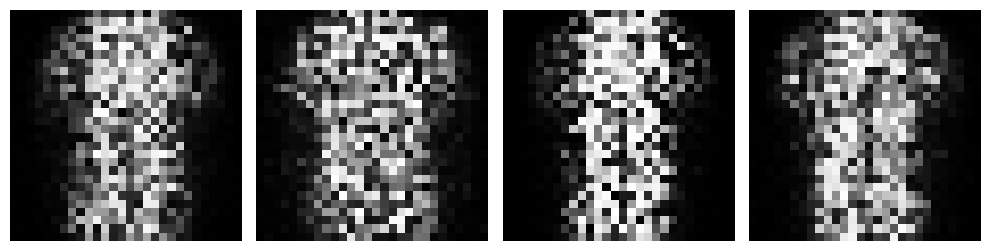

2/2 [==============================] - 0s 3ms/step
Epoch: 101, Batch: 0, D Loss: 0.6899586319923401, D Acc: 0.5, G Loss: 0.8175947070121765
2/2 [==============================] - 0s 3ms/step
Epoch: 101, Batch: 50, D Loss: 0.6928861737251282, D Acc: 0.5, G Loss: 0.8122604489326477
2/2 [==============================] - 0s 3ms/step
Epoch: 102, Batch: 0, D Loss: 0.6865840256214142, D Acc: 0.5, G Loss: 0.8264611959457397
2/2 [==============================] - 0s 3ms/step
Epoch: 102, Batch: 50, D Loss: 0.6864484548568726, D Acc: 0.5, G Loss: 0.8117401003837585
2/2 [==============================] - 0s 3ms/step
Epoch: 103, Batch: 0, D Loss: 0.6877612471580505, D Acc: 0.5, G Loss: 0.8118079304695129
2/2 [==============================] - 0s 3ms/step
Epoch: 103, Batch: 50, D Loss: 0.6912652850151062, D Acc: 0.5, G Loss: 0.8176285624504089
2/2 [==============================] - 0s 3ms/step
Epoch: 104, Batch: 0, D Loss: 0.696956604719162, D Acc: 0.49000000953674316, G Loss: 0.8140174150466919
2/

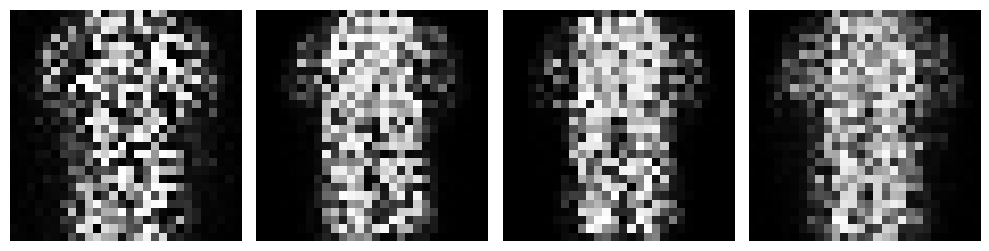

2/2 [==============================] - 0s 3ms/step
Epoch: 111, Batch: 0, D Loss: 0.697670191526413, D Acc: 0.5, G Loss: 0.8126839399337769
2/2 [==============================] - 0s 3ms/step
Epoch: 111, Batch: 50, D Loss: 0.6867370307445526, D Acc: 0.5, G Loss: 0.8227530121803284
2/2 [==============================] - 0s 3ms/step
Epoch: 112, Batch: 0, D Loss: 0.6905568838119507, D Acc: 0.5, G Loss: 0.8064815402030945
2/2 [==============================] - 0s 3ms/step
Epoch: 112, Batch: 50, D Loss: 0.689741313457489, D Acc: 0.5, G Loss: 0.8109142780303955
2/2 [==============================] - 0s 3ms/step
Epoch: 113, Batch: 0, D Loss: 0.6901459097862244, D Acc: 0.44999998807907104, G Loss: 0.8116650581359863
2/2 [==============================] - 0s 3ms/step
Epoch: 113, Batch: 50, D Loss: 0.6945900022983551, D Acc: 0.5, G Loss: 0.79997718334198
2/2 [==============================] - 0s 2ms/step
Epoch: 114, Batch: 0, D Loss: 0.695114940404892, D Acc: 0.49000000953674316, G Loss: 0.8129835

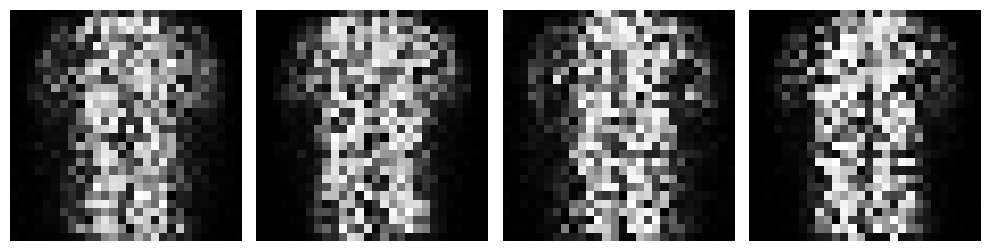

2/2 [==============================] - 0s 3ms/step
Epoch: 121, Batch: 0, D Loss: 0.6936036944389343, D Acc: 0.49000000953674316, G Loss: 0.8089887499809265
2/2 [==============================] - 0s 3ms/step
Epoch: 121, Batch: 50, D Loss: 0.6917226910591125, D Acc: 0.5, G Loss: 0.7983734011650085
2/2 [==============================] - 0s 3ms/step
Epoch: 122, Batch: 0, D Loss: 0.6924028396606445, D Acc: 0.5, G Loss: 0.8090518116950989
2/2 [==============================] - 0s 2ms/step
Epoch: 122, Batch: 50, D Loss: 0.6900031566619873, D Acc: 0.5, G Loss: 0.8087986707687378
2/2 [==============================] - 0s 3ms/step
Epoch: 123, Batch: 0, D Loss: 0.6903052628040314, D Acc: 0.5, G Loss: 0.810301661491394
2/2 [==============================] - 0s 3ms/step
Epoch: 123, Batch: 50, D Loss: 0.6912937164306641, D Acc: 0.5, G Loss: 0.7990648746490479
2/2 [==============================] - 0s 3ms/step
Epoch: 124, Batch: 0, D Loss: 0.6865781843662262, D Acc: 0.5, G Loss: 0.8146598935127258
2/

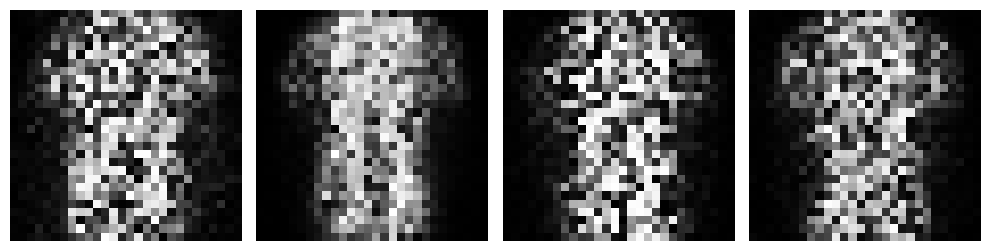

2/2 [==============================] - 0s 3ms/step
Epoch: 131, Batch: 0, D Loss: 0.6938988268375397, D Acc: 0.5, G Loss: 0.7882074117660522
2/2 [==============================] - 0s 3ms/step
Epoch: 131, Batch: 50, D Loss: 0.6878321170806885, D Acc: 0.5, G Loss: 0.8153950572013855
2/2 [==============================] - 0s 4ms/step
Epoch: 132, Batch: 0, D Loss: 0.6928230226039886, D Acc: 0.5, G Loss: 0.8007460236549377
2/2 [==============================] - 0s 2ms/step
Epoch: 132, Batch: 50, D Loss: 0.6927398145198822, D Acc: 0.5, G Loss: 0.8040685057640076
2/2 [==============================] - 0s 3ms/step
Epoch: 133, Batch: 0, D Loss: 0.6934218406677246, D Acc: 0.5, G Loss: 0.7989578247070312
2/2 [==============================] - 0s 3ms/step
Epoch: 133, Batch: 50, D Loss: 0.6913389563560486, D Acc: 0.5, G Loss: 0.8055850267410278
2/2 [==============================] - 0s 3ms/step
Epoch: 134, Batch: 0, D Loss: 0.691105306148529, D Acc: 0.5, G Loss: 0.7991725206375122
2/2 [=============

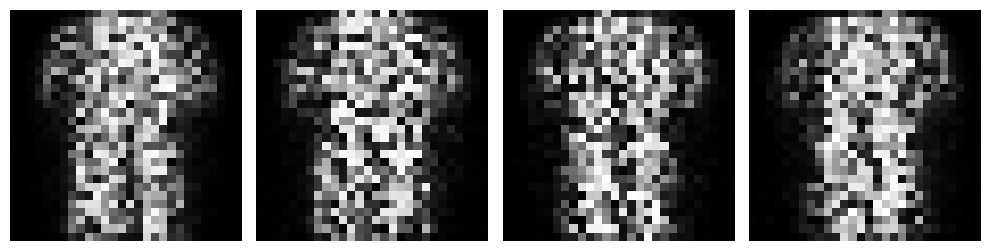

2/2 [==============================] - 0s 3ms/step
Epoch: 141, Batch: 0, D Loss: 0.6902538537979126, D Acc: 0.5, G Loss: 0.8045142889022827
2/2 [==============================] - 0s 5ms/step
Epoch: 141, Batch: 50, D Loss: 0.6971935331821442, D Acc: 0.49000000953674316, G Loss: 0.8034986853599548
2/2 [==============================] - 0s 3ms/step
Epoch: 142, Batch: 0, D Loss: 0.6905238926410675, D Acc: 0.47999998927116394, G Loss: 0.8055719137191772
2/2 [==============================] - 0s 3ms/step
Epoch: 142, Batch: 50, D Loss: 0.6861561238765717, D Acc: 0.5, G Loss: 0.8100153207778931
2/2 [==============================] - 0s 3ms/step
Epoch: 143, Batch: 0, D Loss: 0.6898363530635834, D Acc: 0.5, G Loss: 0.800571084022522
2/2 [==============================] - 0s 3ms/step
Epoch: 143, Batch: 50, D Loss: 0.6914049088954926, D Acc: 0.5, G Loss: 0.8003583550453186
2/2 [==============================] - 0s 3ms/step
Epoch: 144, Batch: 0, D Loss: 0.6911785006523132, D Acc: 0.5, G Loss: 0.801

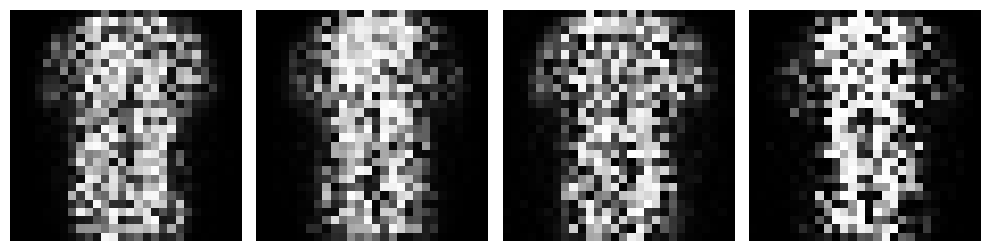

2/2 [==============================] - 0s 3ms/step
Epoch: 151, Batch: 0, D Loss: 0.689601480960846, D Acc: 0.5, G Loss: 0.8042694926261902
2/2 [==============================] - 0s 3ms/step
Epoch: 151, Batch: 50, D Loss: 0.6907883882522583, D Acc: 0.5, G Loss: 0.7997728586196899
2/2 [==============================] - 0s 3ms/step
Epoch: 152, Batch: 0, D Loss: 0.6917466223239899, D Acc: 0.5, G Loss: 0.8013619780540466
2/2 [==============================] - 0s 3ms/step
Epoch: 152, Batch: 50, D Loss: 0.6896786093711853, D Acc: 0.5, G Loss: 0.8019692897796631
2/2 [==============================] - 0s 3ms/step
Epoch: 153, Batch: 0, D Loss: 0.6900055706501007, D Acc: 0.5, G Loss: 0.803953230381012
2/2 [==============================] - 0s 3ms/step
Epoch: 153, Batch: 50, D Loss: 0.692234605550766, D Acc: 0.49000000953674316, G Loss: 0.8028371334075928
2/2 [==============================] - 0s 3ms/step
Epoch: 154, Batch: 0, D Loss: 0.6902714669704437, D Acc: 0.5, G Loss: 0.8043405413627625
2/2 

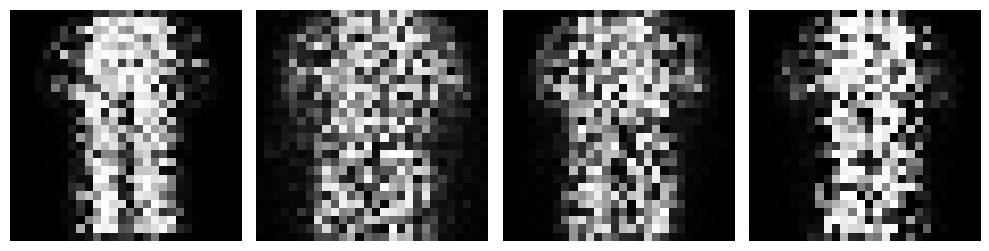

2/2 [==============================] - 0s 3ms/step
Epoch: 161, Batch: 0, D Loss: 0.6924285590648651, D Acc: 0.5, G Loss: 0.8008605241775513
2/2 [==============================] - 0s 3ms/step
Epoch: 161, Batch: 50, D Loss: 0.6925879120826721, D Acc: 0.5, G Loss: 0.8020936846733093
2/2 [==============================] - 0s 3ms/step
Epoch: 162, Batch: 0, D Loss: 0.694845587015152, D Acc: 0.5, G Loss: 0.8020315766334534
2/2 [==============================] - 0s 3ms/step
Epoch: 162, Batch: 50, D Loss: 0.6895162761211395, D Acc: 0.5, G Loss: 0.8045588731765747
2/2 [==============================] - 0s 2ms/step
Epoch: 163, Batch: 0, D Loss: 0.6928350627422333, D Acc: 0.5, G Loss: 0.8023234605789185
2/2 [==============================] - 0s 3ms/step
Epoch: 163, Batch: 50, D Loss: 0.6948585510253906, D Acc: 0.49000000953674316, G Loss: 0.7949135303497314
2/2 [==============================] - 0s 3ms/step
Epoch: 164, Batch: 0, D Loss: 0.6896025240421295, D Acc: 0.5, G Loss: 0.7949975728988647
2/

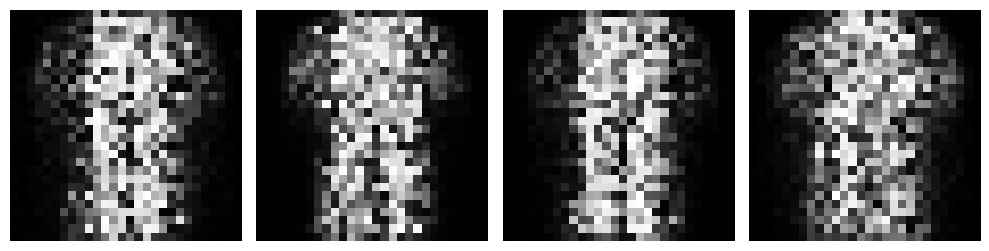

2/2 [==============================] - 0s 3ms/step
Epoch: 171, Batch: 0, D Loss: 0.694244772195816, D Acc: 0.5, G Loss: 0.7937811017036438
2/2 [==============================] - 0s 4ms/step
Epoch: 171, Batch: 50, D Loss: 0.694334864616394, D Acc: 0.5, G Loss: 0.8044101595878601
2/2 [==============================] - 0s 3ms/step
Epoch: 172, Batch: 0, D Loss: 0.6856451332569122, D Acc: 0.47999998927116394, G Loss: 0.8206238746643066
2/2 [==============================] - 0s 3ms/step
Epoch: 172, Batch: 50, D Loss: 0.6902790069580078, D Acc: 0.5, G Loss: 0.7921328544616699
2/2 [==============================] - 0s 4ms/step
Epoch: 173, Batch: 0, D Loss: 0.6906607151031494, D Acc: 0.5, G Loss: 0.7973112463951111
2/2 [==============================] - 0s 3ms/step
Epoch: 173, Batch: 50, D Loss: 0.6932706534862518, D Acc: 0.5, G Loss: 0.7969700694084167
2/2 [==============================] - 0s 3ms/step
Epoch: 174, Batch: 0, D Loss: 0.6894875764846802, D Acc: 0.5, G Loss: 0.8070642352104187
2/2

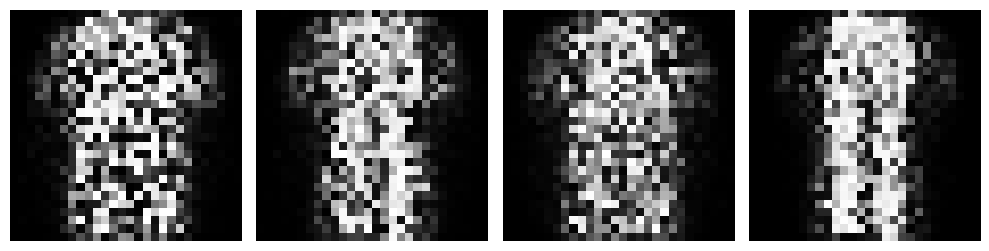

2/2 [==============================] - 0s 3ms/step
Epoch: 181, Batch: 0, D Loss: 0.6947348117828369, D Acc: 0.5, G Loss: 0.7908960580825806
2/2 [==============================] - 0s 2ms/step
Epoch: 181, Batch: 50, D Loss: 0.6909754872322083, D Acc: 0.5, G Loss: 0.7938269972801208
2/2 [==============================] - 0s 3ms/step
Epoch: 182, Batch: 0, D Loss: 0.6887036859989166, D Acc: 0.5, G Loss: 0.7989296913146973
2/2 [==============================] - 0s 2ms/step
Epoch: 182, Batch: 50, D Loss: 0.6925521492958069, D Acc: 0.5, G Loss: 0.794822096824646
2/2 [==============================] - 0s 3ms/step
Epoch: 183, Batch: 0, D Loss: 0.6913451850414276, D Acc: 0.5, G Loss: 0.7972856163978577
2/2 [==============================] - 0s 3ms/step
Epoch: 183, Batch: 50, D Loss: 0.6989687085151672, D Acc: 0.49000000953674316, G Loss: 0.7924286127090454
2/2 [==============================] - 0s 3ms/step
Epoch: 184, Batch: 0, D Loss: 0.6888881623744965, D Acc: 0.5, G Loss: 0.801329493522644
2/2

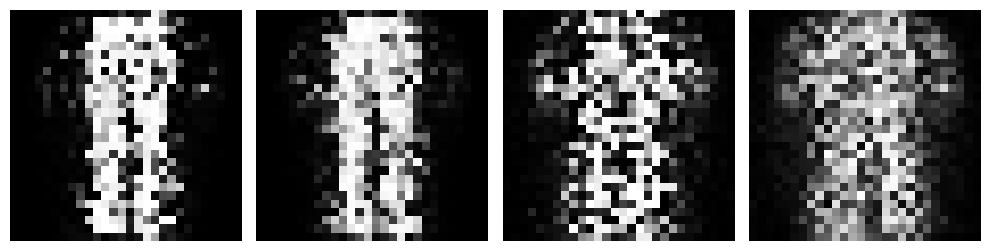

2/2 [==============================] - 0s 3ms/step
Epoch: 191, Batch: 0, D Loss: 0.6882330775260925, D Acc: 0.5, G Loss: 0.7988523244857788
2/2 [==============================] - 0s 3ms/step
Epoch: 191, Batch: 50, D Loss: 0.6884009540081024, D Acc: 0.5, G Loss: 0.803722083568573
2/2 [==============================] - 0s 3ms/step
Epoch: 192, Batch: 0, D Loss: 0.6921381652355194, D Acc: 0.5, G Loss: 0.7951216101646423
2/2 [==============================] - 0s 3ms/step
Epoch: 192, Batch: 50, D Loss: 0.6909399032592773, D Acc: 0.5, G Loss: 0.794659435749054
2/2 [==============================] - 0s 3ms/step
Epoch: 193, Batch: 0, D Loss: 0.6876296401023865, D Acc: 0.5, G Loss: 0.7958351373672485
2/2 [==============================] - 0s 3ms/step
Epoch: 193, Batch: 50, D Loss: 0.6885495781898499, D Acc: 0.5, G Loss: 0.79144287109375
2/2 [==============================] - 0s 3ms/step
Epoch: 194, Batch: 0, D Loss: 0.6912763714790344, D Acc: 0.5, G Loss: 0.805022120475769
2/2 [=================

In [20]:
#fitting model
gan_model.train(200)

1/1 [==============================] - 0s 21ms/step


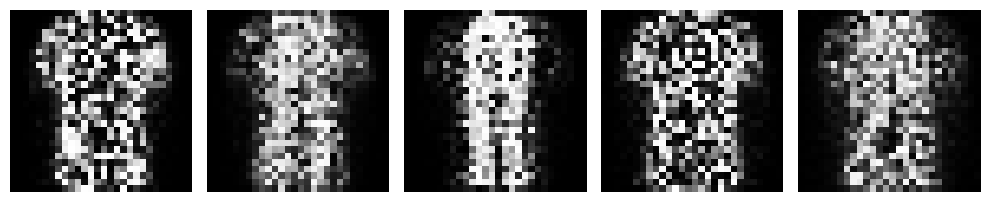

In [23]:
gan_model.preview_generated_images(5)

## FID Evaluation

In [42]:
from keras.applications.vgg16 import VGG16
from scipy import linalg

def resize_image(img):
    img = np.repeat(img, 3, axis=-1)
    return tf.image.resize(img, (32, 32))

vgg_model = VGG16(include_top=False, pooling='avg', input_shape=(32, 32, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [45]:
def fid_score(real_images, generated_images):
    # flatten real or artificial images if the dimensions are not 2D
    if real_images.ndim > 2:
        real_images = real_images.reshape(real_images.shape[0], -1)
    if generated_images.ndim > 2:
        generated_images = generated_images.reshape(generated_images.shape[0], -1)

    #calculate the mean and covariance of the fake images
    mu_real = np.mean(real_images, axis=0)
    sigma_real = np.cov(real_images, rowvar=False)

    #calculate the mean and covariance of the original image
    mu_gen = np.mean(generated_images, axis=0)
    sigma_gen = np.cov(generated_images, rowvar=False)

    mean_diff = np.sum((mu_real - mu_gen) ** 2)

    cov_sqrt = linalg.sqrtm(sigma_real.dot(sigma_gen), disp=False)[0].real
    
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real
    
    #calculates FID Score
    fid_score = mean_diff + np.trace(sigma_real + sigma_gen - 2 * cov_sqrt)
    return fid_score

def evaluate_fid(test_data):
    n_samples = test_data.shape[0]
    
    #generate artificial images
    noise = np.random.randn(n_samples, noise_dim)
    labels = np.random.randint(0, 2, n_samples).reshape(-1, 1)
    
    fake_images = gan_model.generator.predict([noise, labels])
    fake_images = resize_image(fake_images)
    
    #resize image data
    test_data = test_data.reshape(-1, 28, 28, 1)
    test_data = resize_image(test_data)
    
    #extract features from real and fake images
    real_data = vgg_model.predict(test_data)
    fake_data = vgg_model.predict(fake_images)
    
    #calculate FID score
    return fid_score(real_data,fake_data)

print('FID score result  : ',evaluate_fid(test_img_data))


38/38 [==============================] - 0s 6ms/step
FID score result  :  104.2079583250682


The FID score of this model is 104.2, indicating that the model can generate images that are different from the original image dataset. Moreover, this score also indicates that there is room for the model to improve the quality and similarity with the original image data.